<br> 


# Hyperparameter Tuning

<br><br>
<hr> <br> 

In [ ]:
# !pip install shap
import shap

location = 'datasets/'

import os, random, time, fsspec, gunzip, datetime, requests, copy, inspect, collections, itertools

import pandas as pd, pandas_datareader as pd_dr, re
import numpy as np, seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn, sklearn_pandas
from sklearn import *
import missingno as msno
import h5py, pickle, urllib

import scipy, scipy.stats as stats, random, math
from sklearn.pipeline import Pipeline
from math import sqrt
import joblib, re

import matplotlib, graphviz
import matplotlib.pyplot as plt
from matplotlib import *
plt.style.use('dark_background')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost; import xgboost as xgb

import hyperopt
import hyperopt as hopt

%matplotlib inline
%config Completer.use_jedi = False
%matplotlib inline

import catboost
from catboost import *
import catboost, pandas_profiling

np.random.seed(1)

## Grid Search

In [158]:
#  grid search func for a model

def grdSrc_GradBoost( alpha, maxDepth_val, subSample_val ):
    
    model_obj1 = sklearn.ensemble.GradientBoostingClassifier( learning_rate= alpha, max_depth= maxDepth_val, subsample= subSample_val )
    model_obj1.fit( xtrn,ytrn )
    
    # Return the hyperparameters & score
    return(     [  alpha, maxDepth_val, subSample_val,  sklearn.metrics.accuracy_score( ytst,model_obj1.predict(xtst) )  ]    )

In [160]:
# data prep
credit_df = pd.read_csv( location + 'credit-card-full.csv', index_col= [0] )

credit_df = credit_df.sample( n= 600, replace= False )

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(
                                    credit_df.drop(columns='default payment next month'), credit_df[['default payment next month']],
                                    test_size= 30/100, random_state= 10
                                                                 )

print( f'{xtrn.shape}, {ytrn.shape}, \n\n{ytrn.head(2)}'  )
xtrn.head(2)

(420, 23), (420, 1), 

       default payment next month
ID                               
27187                           0
24114                           0


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
27187,200000,1,1,2,28,-1,-1,-1,-1,-1,-1,5838,2256,9552,4215,3400,3286,2256,9588,5135,3487,3295,7791
24114,280000,1,2,1,29,-2,-2,-1,2,2,-2,-650,-650,2057,650,3072,3330,0,2707,3,3072,3330,499


In [162]:
# grid search by calling udf Gridsearch 

alpha_ls = np.linspace( 0.1,0.9,3 );   maxDepth_ls = np.arange( 2,5,2 );   subSample_ls = np.linspace( 0.4,1,3 )
alpha_ls = np.linspace( 0.1,0.9,2 );   maxDepth_ls = np.arange( 2,5,2 );   subSample_ls = np.linspace( 0.4,1,1 )

result_ls = []

warnings.filterwarnings( action= 'ignore' )

for e_alpha in alpha_ls:
    for e_maxDepth in maxDepth_ls:
        for e_subSample in subSample_ls:
            
            result_ls.append(
                                grdSrc_GradBoost( alpha= e_alpha, maxDepth_val= e_maxDepth, subSample_val= e_subSample )
                            )

In [163]:
result_df = pd.DataFrame( result_ls, columns= inspect.getfullargspec(grdSrc_GradBoost).args + ['accuScore'] )
result_df

,alpha,maxDepth_val,subSample_val,accuScore
0,0.1,2,0.4,0.788889
1,0.1,4,0.4,0.783333
2,0.9,2,0.4,0.722222
3,0.9,4,0.4,0.672222


### Grid Search with scikit-learn

#### Steps in a Grid Search
    - 1. Select an algorithm or estimator to tune the hyperparams
    - 2. Define which hyperparameters we will tune
    - 3. Define a range of values for each hyperparameter
    - 4. Decide a cross-validation scheme
    = 5. Define a scoring function to determine which model hyperparam's grid square is the best
    - 6. Include extra useful information or functions

In [58]:
# to see all the metrics
print( sklearn.metrics.SCORERS.keys() )

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### Grid search output

```
return_train_score = True

```

In [164]:
rF_est = sklearn.ensemble.RandomForestClassifier( criterion= 'entropy' )

hparamSpace = {   'max_depth': [2,4,8],
                  'max_features': [ 'auto', 'sqrt' ]   }

rF_GrdSrc_est = sklearn.model_selection.GridSearchCV( estimator= rF_est, param_grid= hparamSpace, scoring= ['roc_auc','roc_auc_ovo'], cv= 3,
                                                      refit= 'roc_auc', return_train_score= True, n_jobs= os.cpu_count()-1
                                                    )
rF_GrdSrc_est.fit( xtrn, ytrn )

GridSearchCV(cv=3, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=11,
             param_grid={'max_depth': [2, 4, 8],
                         'max_features': ['auto', 'sqrt']},
             refit='roc_auc', return_train_score=True,
             scoring=['roc_auc', 'roc_auc_ovo'])

In [165]:
CVresult_GrdSrc1 = pd.DataFrame( rF_GrdSrc_est.cv_results_ )

print( CVresult_GrdSrc1.shape ); CVresult_GrdSrc1.head(3)

(6, 29)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo,split0_train_roc_auc_ovo,split1_train_roc_auc_ovo,split2_train_roc_auc_ovo,mean_train_roc_auc_ovo,std_train_roc_auc_ovo
0,0.167038,0.004321,0.017337,0.000472,2,auto,"{'max_depth': 2, 'max_features': 'auto'}",0.738087,0.745277,0.759615,0.747660,0.008949,6,0.870150,0.848146,0.845107,0.854468,0.011158,0.738087,0.745277,0.759615,0.747660,0.008949,6,0.870150,0.848146,0.845107,0.854468,0.011158
1,0.164037,0.002161,0.017337,0.000471,2,sqrt,"{'max_depth': 2, 'max_features': 'sqrt'}",0.737391,0.752868,0.757422,0.749227,0.008573,5,0.876603,0.845235,0.837058,0.852965,0.017044,0.737391,0.752868,0.757422,0.749227,0.008573,5,0.876603,0.845235,0.837058,0.852965,0.017044
2,0.177707,0.002625,0.016670,0.000471,4,auto,"{'max_depth': 4, 'max_features': 'auto'}",0.727304,0.757085,0.823212,0.769200,0.040080,1,0.957321,0.950766,0.946143,0.951410,0.004586,0.727304,0.757085,0.823212,0.769200,0.040080,1,0.957321,0.950766,0.946143,0.951410,0.004586


<h4>

```
return_train_score = False

```

In [166]:
hparamSpace = {   'max_depth': [2,4,8], 'min_samples_split': [0.4,0.6,],
                  'max_features': [ 'auto', 'sqrt' ]   }

rF_GrdSrc_est = sklearn.model_selection.GridSearchCV( estimator= rF_est, param_grid= hparamSpace, scoring= ['roc_auc','roc_auc_ovo'], cv= 3,
                                                      refit= 'roc_auc', return_train_score= False, n_jobs= os.cpu_count()-1
                                                    )
rF_GrdSrc_est.fit( xtrn, ytrn )

CVresult_GrdSrc2 = pd.DataFrame( rF_GrdSrc_est.cv_results_ )
print( CVresult_GrdSrc2.shape ); CVresult_GrdSrc2.head(3)

(12, 20)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo
0,0.185041,0.019821,0.016004,3.371748e-07,2,auto,0.4,"{'max_depth': 2, 'max_features': 'auto', 'min_...",0.729043,0.736842,0.768219,0.744701,0.016931,10,0.729043,0.736842,0.768219,0.744701,0.016931,10
1,0.168371,0.026718,0.016337,4.715390e-04,2,auto,0.6,"{'max_depth': 2, 'max_features': 'auto', 'min_...",0.755304,0.743927,0.748482,0.749238,0.004675,7,0.755304,0.743927,0.748482,0.749238,0.004675,7
2,0.162703,0.030659,0.018337,3.300379e-03,2,sqrt,0.4,"{'max_depth': 2, 'max_features': 'sqrt', 'min_...",0.742435,0.752362,0.755735,0.750177,0.005645,6,0.742435,0.752362,0.755735,0.750177,0.005645,6


In [167]:
# extracting the best top 3 hyperparam tuning

top3CVresults =   CVresult_GrdSrc2[ CVresult_GrdSrc2.rank_test_roc_auc_ovo <= 3 ]
top3CVresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo
5,0.150034,0.009418,0.016670,4.717076e-04,4,auto,0.6,"{'max_depth': 4, 'max_features': 'auto', 'min_...",0.757913,0.768050,0.760796,0.762253,0.004265,2,0.757913,0.768050,0.760796,0.762253,0.004265,2
7,0.151700,0.003860,0.016004,3.371748e-07,4,sqrt,0.6,"{'max_depth': 4, 'max_features': 'sqrt', 'min_...",0.748870,0.750843,0.767038,0.755584,0.008139,3,0.748870,0.750843,0.767038,0.755584,0.008139,3
9,0.147366,0.003400,0.016337,4.714829e-04,8,auto,0.6,"{'max_depth': 8, 'max_features': 'auto', 'min_...",0.757043,0.765013,0.778677,0.766911,0.008933,1,0.757043,0.765013,0.778677,0.766911,0.008933,1


In [168]:
# the best model

CVresult_GrdSrc2.loc[ CVresult_GrdSrc2.rank_test_roc_auc_ovo == 1, : ]
# OR
CVresult_GrdSrc2.loc[ [rF_GrdSrc_est.best_index_] ]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo
9,0.147366,0.0034,0.016337,0.000471,8,auto,0.6,"{'max_depth': 8, 'max_features': 'auto', 'min_...",0.757043,0.765013,0.778677,0.766911,0.008933,1,0.757043,0.765013,0.778677,0.766911,0.008933,1


#### The best model properties

In [169]:
print( rF_GrdSrc_est.best_estimator_, '\n\n', rF_GrdSrc_est.best_index_, '\n\n', rF_GrdSrc_est.best_params_, '\n\n', rF_GrdSrc_est.best_score_ )

RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=0.6) 

 9 

 {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 0.6} 

 0.766911478808504


#### Extra information

In [170]:
print( rF_GrdSrc_est.scorer_, '\n\n', rF_GrdSrc_est.n_splits_, '\n\n', rF_GrdSrc_est.refit_time_ )

{'roc_auc': make_scorer(roc_auc_score, needs_threshold=True), 'roc_auc_ovo': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovo)} 

 3 

 0.0980217456817627


In [171]:
# Get the max_depth from the best-performing model
rF_GrdSrc_est.best_estimator_.max_depth

8

#### Using the best results

In [173]:
# directly use the estimator obj if refit = True OR refit= 'roc_auc' (one of the score)
rF_GrdSrc_est.predict( xtst )

# OR use best estimator property of the class as
print( rF_GrdSrc_est.best_estimator_.predict( xtst ) )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Random Search

### Grid Search func

#### Probability justification of a Random Search

In [71]:
# Probability of missing good model during RandomSearch is
# ( 1 - Pgood ) x ( 1 - Pgood ) x ( 1 - Pgood ) x ...... x ( 1 - Pgood )  --> ( 1 - Pgood )^n

# Pgood = is  the prob of good hparam i.e --> (total no. of good hparam squares) / ( total no. of hparam sqs ) 

# lets say we have 2 hparams and 10 values of each hparam, then:
# total no. of hparam sqs = 10 x 10 = 100
# and lets say we have 5 hparams sq which are good then:
Pgood = 5/100

# prob of missing good model for 15 trials
n = 15
Pmiss = ( 1- 5/100 )**(15); print( 'chance of missing good model  --> ', round(Pmiss,2) )

## Prob of missing good model with 95% chance with n trials. So how many trials we need so that we will have 95% chance of getting good hparam (green box)?
# --> we have ( 1 - 0.05 )^n chance to miss everything  --> we have 1 - ( 1- 0.05 )^n chance to get there (good hparam)

# solve:   1 - ( 1 - 0.05 )^ n  > = 95/100
# n >= log0.95 (0.05)  
n = math.log( 0.05, 0.95 ); print(  f'n >= {round(n)}' )

chance of missing good model  -->  0.46
n >= 58


<br>

### Random Search func

<br>

In [174]:
## set some hparams lists

num_hp = 100
alpha_ls = np.linspace( 0.1,0.9,10 );   maxDepth_ls = list( range(3,10) );   subSample_ls = list( np.linspace(0.4,1,10) )


hparam_ls = [ alpha_ls, maxDepth_ls, subSample_ls ]

## create list of products of hparams

hparamProduct_ls = [  list(e_product) for e_product in itertools.product( *hparam_ls )  ]
    
## select 100 hparams randomly
rnd_hparam = random.sample( population= hparamProduct_ls, k= num_hp )

In [176]:
result_ls = []

for e_hparam in rnd_hparam:
    result_ls.append(    grdSrc_GradBoost( alpha= e_hparam[0], maxDepth_val= e_hparam[1], subSample_val= e_hparam[2] )    )
    
result_df = pd.DataFrame( result_ls, columns= inspect.getfullargspec(grdSrc_GradBoost).args + ['accuScore'] )

print( result_df.shape ); result_df.head()

(100, 4)


,alpha,maxDepth_val,subSample_val,accuScore
0,0.900000,4,0.466667,0.505556
1,0.811111,6,0.600000,0.755556
2,0.277778,9,0.466667,0.794444
3,0.366667,5,0.600000,0.772222
4,0.455556,5,0.733333,0.777778


####  Visualize Random search hyper param space

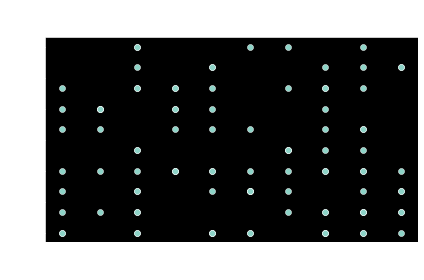

In [186]:
fg,ax = plt.subplots( figsize= (6,4) )

sns.scatterplot( x= 'alpha', y= 'subSample_val', data= result_df, ax= ax )

ax.set( title= 'Distribution of randomly choosen hyperparams \n'  )
plt.tight_layout(); plt.show()

### Random Search with scikit-learn

#### Steps in a RandomSearch
    - 1. Select an algorithm or estimator to tune the hyperparams
    - 2. Define which hyperparameters we will tune
    - 3. Define a range of values for each hyperparameter
    - 4. Decide a cross-validation scheme
    - 5. Define a scoring function to determine which model hyperparam's grid square is the best
    - 6. Include extra useful information or functions
    - 7. Decide how many samples to take

In [187]:
hparamSpace = {   'max_depth': [2,4,8], 'min_samples_split': [0.4,0.6,],
                  'max_features': [ 'auto', 'sqrt' ]   }

rF_RndSrc_est = sklearn.model_selection.RandomizedSearchCV(  estimator= rF_est, param_distributions= hparamSpace, n_iter= 50, 
                                                             scoring= ['roc_auc','roc_auc_ovo'], cv= 3,
                                                             refit= 'roc_auc', return_train_score= False, n_jobs= os.cpu_count()-1
                                                           )
rF_RndSrc_est.fit( xtrn, ytrn )

CVresult_RndSrc = pd.DataFrame( rF_RndSrc_est.cv_results_ )
print( CVresult_RndSrc.shape ); CVresult_RndSrc.head(3)

(12, 20)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo
0,0.167371,0.002625,0.022671,0.006601,0.4,auto,2,"{'min_samples_split': 0.4, 'max_features': 'au...",0.743652,0.744433,0.756410,0.748165,0.005839,9,0.743652,0.744433,0.756410,0.748165,0.005839,9
1,0.154035,0.007120,0.020671,0.002358,0.6,auto,2,"{'min_samples_split': 0.6, 'max_features': 'au...",0.758261,0.754217,0.781883,0.764787,0.012201,2,0.758261,0.754217,0.781883,0.764787,0.012201,2
2,0.182708,0.002495,0.030673,0.012922,0.4,sqrt,2,"{'min_samples_split': 0.4, 'max_features': 'sq...",0.745739,0.754892,0.736842,0.745824,0.007369,10,0.745739,0.754892,0.736842,0.745824,0.007369,10


<br><hr><br>

## Advanced Hyperparameter Tuning Methods - Informed Search

#### Key Concepts

    - Advanced hyperparameter tuning methodologies - 'Informed Search':
    - Coarse-to-Fine, Bayesian & Genetic hyperparameter tuning algorithms
<br>

### ` Coarse-to-Fine`

#### Methodology Steps:

>   
    - 1. Random-Search
    - 2. Review and confirm Promising areas
    - 3. Optional: Random-Search to further narrow the Promising Area and then Grid-Search in the small Promising area
    - 4. Continue until optimal score is obtained

In [13]:
# data prep
credit_df = pd.read_csv( location + 'credit-card-full.csv', index_col= [0] ).sample( n= 1000, replace= False )

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(  credit_df.drop(columns='default payment next month'), credit_df['default payment next month'].to_numpy(),
                                                                    test_size= 30/100, random_state= 10  )
print( f'{xtrn.shape}, {ytrn.shape}, \n\n{ytrn[:10]}'  );  xtrn.head(2)

(700, 23), (700,), 

[1 0 0 0 0 0 0 0 0 0]


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
13998,90000,1,3,1,31,1,2,2,3,5,5,63276,61693,75670,83772,83401,81487,0,15000,10000,1500,0,1500
20548,50000,1,1,2,27,-1,0,0,0,-1,-1,33567,0,28971,30437,14106,794,2034,0,2500,1024,397,21885


In [74]:
rF_est = sklearn.ensemble.RandomForestClassifier( )

hparamSpace =  {      'max_depth': np.arange( 3,50,3 ), 'min_samples_split': np.linspace( 0.2,0.9,8 ), 'n_estimators': np.arange(10,501),
                      'criterion': [ 'gini', 'entropy' ], 'max_features': [ 'log2', 'sqrt' ]                      }

rF_RndSrc_est = sklearn.model_selection.RandomizedSearchCV(   estimator= rF_est, param_distributions= hparamSpace, n_iter= 1000, 
                                                              scoring= ['accuracy'], cv= 7,
                                                              refit= 'accuracy', return_train_score= False, n_jobs= os.cpu_count()-1
                                                           )
%time rF_RndSrc_est.fit( xtrn, ytrn )

CVresult_RndSrc_df = pd.DataFrame( rF_RndSrc_est.cv_results_ )

print( CVresult_RndSrc_df.shape ); CVresult_RndSrc_df.head(3)

Wall time: 4min 16s
(1000, 20)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,param_max_depth,param_criterion,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.595848,0.027494,0.041152,0.001246,412,0.8,sqrt,21,gini,"{'n_estimators': 412, 'min_samples_split': 0.8...",0.77,0.78,0.78,0.78,0.78,0.78,0.78,0.778571,0.003499,288
1,0.086734,0.021094,0.006859,0.000350,50,0.8,sqrt,24,gini,"{'n_estimators': 50, 'min_samples_split': 0.8,...",0.77,0.78,0.78,0.78,0.78,0.78,0.78,0.778571,0.003499,288
2,0.318643,0.008800,0.024148,0.000833,233,0.7,log2,21,entropy,"{'n_estimators': 233, 'min_samples_split': 0.7...",0.77,0.78,0.78,0.78,0.78,0.78,0.78,0.778571,0.003499,288


In [75]:
CVresult_RndSrc_df.head()
CVresult_RndSrc_df.mean_test_accuracy.unique()

array([0.77857143, 0.78428571, 0.78142857, 0.78857143, 0.78714286,
       0.78571429, 0.78285714, 0.77714286, 0.79285714, 0.79142857,
       0.78571429, 0.77714286, 0.78857143, 0.78714286, 0.77857143,
       0.79      , 0.79571429, 0.78285714, 0.79857143, 0.78      ,
       0.78142857, 0.79285714, 0.78      , 0.78571429, 0.78857143,
       0.79428571, 0.78428571, 0.8       , 0.79      , 0.79      ,
       0.78285714, 0.77571429, 0.79428571, 0.78428571, 0.80285714,
       0.79142857, 0.79142857, 0.8       ])

In [76]:
# get accuracy and hparam columns' names

paramCol_nm = [   CVresult_RndSrc_df.columns[ CVresult_RndSrc_df.columns.str.startswith('mean_test') ][0]   ]
paramCol_nm.extend(   [ 'param_'+e_key for e_key in hparamSpace ]   )

param_df = CVresult_RndSrc_df [ paramCol_nm ]
param_df.head()

,mean_test_accuracy,param_max_depth,param_min_samples_split,param_n_estimators,param_criterion,param_max_features
0,0.778571,21,0.8,412,gini,sqrt
1,0.778571,24,0.8,50,gini,sqrt
2,0.778571,21,0.7,233,entropy,log2
3,0.778571,15,0.9,233,gini,log2
4,0.778571,6,0.8,277,entropy,log2


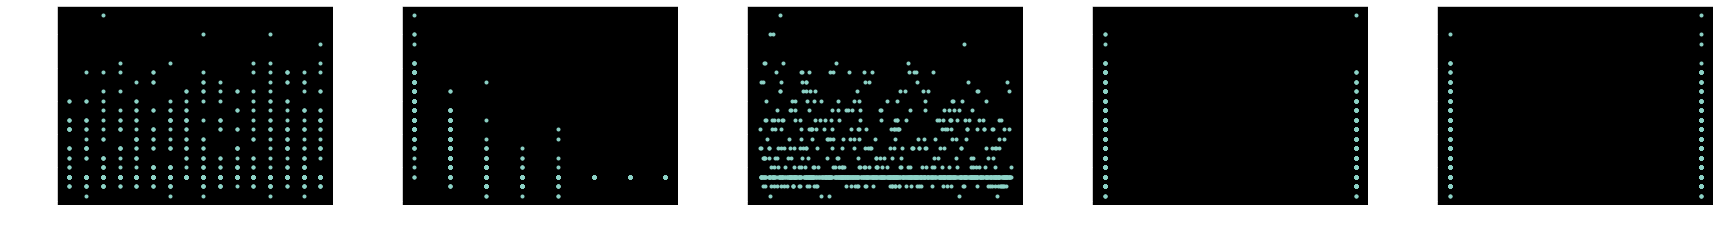

In [77]:
fg,ax = plt.subplots( 1,len(paramCol_nm)-1, figsize= (24,3.5) )

for e_col,e_ax in zip( paramCol_nm[1:], ax.flatten() ):
    
    e_ax.scatter( param_df[e_col], param_df.iloc[:,0], marker= '.' )
    e_ax.set( xlabel= e_col, ylabel= 'model score' )
    
# fg.suptitle( 'Num of category = ' + '\n', fontsize= 18 )
plt.tight_layout(); plt.show()

    based on above hparams vs. score, we choose max_depth --> ( 5, 25 ),        min_sample_split  -->  ( 0.01,  0.25  ),          n_estimator  -->   ( 25, 200 )      

In [83]:
rF_est = sklearn.ensemble.RandomForestClassifier( )

hparamSpace =  {      'max_depth': np.arange( 5,30,2 ), 'min_samples_split': np.linspace( 0.01,0.27,25 ), 'n_estimators': np.arange(25,200),
                      'criterion': [ 'gini', 'entropy' ], 'max_features': [ 'log2', 'sqrt' ]                      }

rF_RndSrc_est = sklearn.model_selection.RandomizedSearchCV(   estimator= rF_est, param_distributions= hparamSpace, n_iter= 1000, 
                                                              scoring= ['accuracy'], cv= 7,
                                                              refit= 'accuracy', return_train_score= False, n_jobs= os.cpu_count()-1
                                                           )
%time rF_RndSrc_est.fit( xtrn, ytrn )
CVresult_RndSrc_df = pd.DataFrame( rF_RndSrc_est.cv_results_ )

Wall time: 2min 29s
(1000, 20)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,param_max_depth,param_criterion,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.285636,0.007652,0.016861,0.000990,163,0.150833,log2,29,gini,"{'n_estimators': 163, 'min_samples_split': 0.1...",0.79,0.77,0.81,0.78,0.83,0.81,0.81,0.800000,0.019272,90
1,0.112311,0.003955,0.008288,0.000452,66,0.259167,sqrt,15,gini,"{'n_estimators': 66, 'min_samples_split': 0.25...",0.75,0.77,0.81,0.77,0.82,0.79,0.81,0.788571,0.024159,751
2,0.301353,0.008014,0.022148,0.006601,169,0.1075,log2,13,gini,"{'n_estimators': 169, 'min_samples_split': 0.1...",0.80,0.77,0.81,0.78,0.83,0.79,0.81,0.798571,0.018844,155


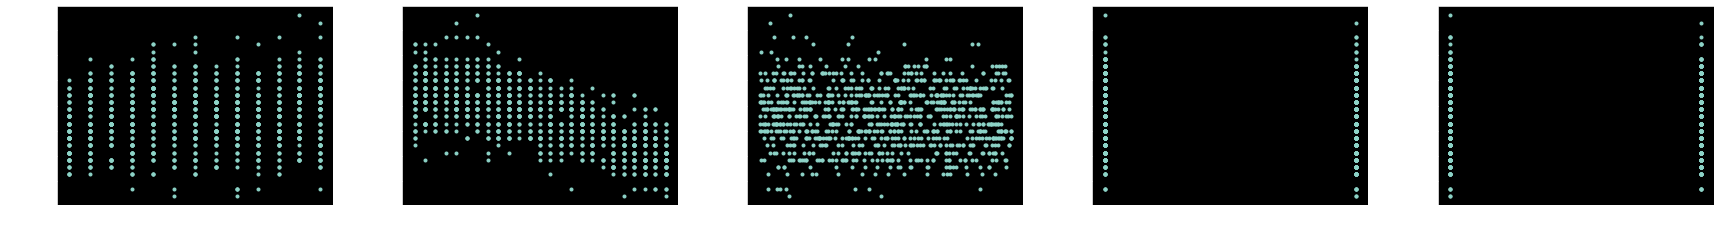

In [84]:
# get accuracy and hparam columns' names
paramCol_nm = [   CVresult_RndSrc_df.columns[ CVresult_RndSrc_df.columns.str.startswith('mean_test') ][0]   ]
paramCol_nm.extend(   [ 'param_'+e_key for e_key in hparamSpace ]   )
param_df = CVresult_RndSrc_df [ paramCol_nm ]

fg,ax = plt.subplots( 1,len(paramCol_nm)-1, figsize= (24,3.5) )
for e_col,e_ax in zip( paramCol_nm[1:], ax.flatten() ):
    e_ax.scatter( param_df[e_col], param_df.iloc[:,0], marker= '.' )
    e_ax.set( xlabel= e_col, ylabel= 'model score' )
plt.tight_layout(); plt.show()

    based on above hparams vs. score, we choose max_depth --> ( 10, 25 ),        min_sample_split  -->  ( 0.01,  0.11  ),          n_estimator  -->   ( 25, 200 )      

Wall time: 2min 31s


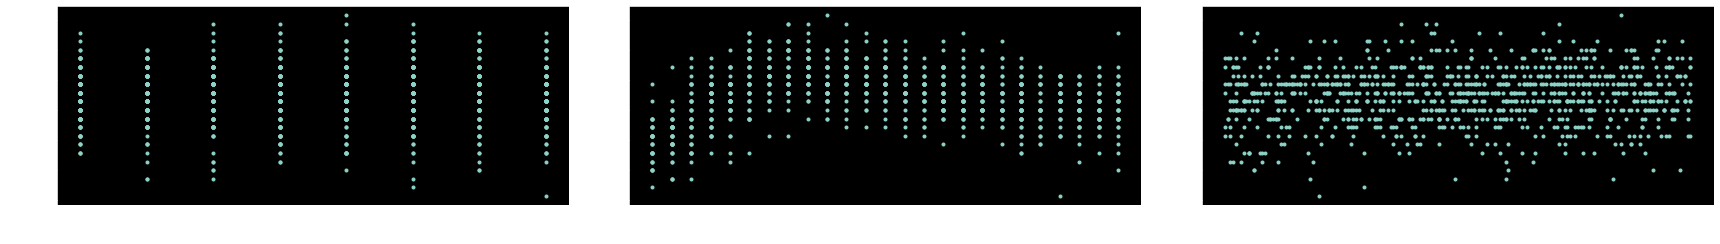

In [218]:
# model 
rF_est = sklearn.ensemble.RandomForestClassifier( )
hparamSpace =  {      'max_depth': np.arange( 10,25,2 ), 'min_samples_split': np.linspace( 0.01,0.11,25 ), 'n_estimators': np.arange(25,200) }
rF_RndSrc_est = sklearn.model_selection.RandomizedSearchCV(   estimator= rF_est, param_distributions= hparamSpace, n_iter= 1000, 
                                                              scoring= ['accuracy'], cv= 7,
                                                              refit= 'accuracy', return_train_score= False, n_jobs= os.cpu_count()-1
                                                           )
%time rF_RndSrc_est.fit( xtrn, ytrn )
CVresult_RndSrc_df = pd.DataFrame( rF_RndSrc_est.cv_results_ )

# get accuracy and hparam columns' names
paramCol_nm = [   CVresult_RndSrc_df.columns[ CVresult_RndSrc_df.columns.str.startswith('mean_test') ][0]   ]
paramCol_nm.extend(   [ 'param_'+e_key for e_key in hparamSpace ]   )
param_df = CVresult_RndSrc_df [ paramCol_nm ]

fg,ax = plt.subplots( 1,len(paramCol_nm)-1, figsize= (24,3.5) )
for e_col,e_ax in zip( paramCol_nm[1:], ax.flatten() ):
    e_ax.scatter( param_df[e_col], param_df.iloc[:,0], marker= '.' )
    e_ax.set( xlabel= e_col, ylabel= 'model score' )
plt.tight_layout(); plt.show()


<br>

<br>

### Bayesian Statistics method

\begin{equation}
\label{eq:bayes}
P(\theta|\textbf{B}) = P(\theta ) \frac{P(\textbf{B} |\theta)}{P(\textbf{B})} 
\end{equation}

#### Library: `Distributed Hyperparameter Optimization - hyperopt`

#### Guidelines:

>   
    - 1. Decide Hyper-param space
    - 2. Build a model based on the hyper-param
    - 3. Get the new Evidence (i.e. the score of the model)  [  𝑃( 𝐁|𝜃 )  ]
    - 4. Update the beliefs and chose better hparams next round    [  𝑃(𝜃|𝐁) ]
    
#### Bayesian hparam tuning steps:

>   
    - 1. Set the Domain: Our Grid (hyperParmSpace)
    - 2. Set the Optimization algo(default TPE)
    - 3. Objective func to MINIMIZE: we will use 1 - Accuracy
    
####  Hyperparam space can be set as:

>    
    Simple numbers
    Choose from a list
    Distribution of values
    
`Hyperopt` <u>does not use</u> point values on the grid but instead each point represents probabilities (eg. uniform distribution) for each hyperparameter value.
<br>

In [102]:
import hyperopt
import hyperopt as hopt

# data prep
credit_df = pd.read_csv( location + 'credit-card-full.csv', index_col= [0] ).sample( n= 1000, replace= False )
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(  credit_df.drop(columns='default payment next month'), credit_df['default payment next month'].to_numpy(),
                                                                    test_size= 30/100, random_state= 10  )

In [254]:
hparamSpace =  {   'max_depth':  hopt.hp.choice( 'max_depth', np.arange(5,30,1,dtype= int) ),
                   'n_estimators': hopt.hp.choice( 'n_estimators', np.arange(20,200,2,dtype= int) ),
                   'min_samples_split': hopt.hp.choice( 'min_samples_split', np.arange(0.01,0.27,0.01,dtype= np.float16) )
               }

## set up an obj func

def hopt_obj( hparamSpace ):
    
   
    rF_est = sklearn.ensemble.GradientBoostingClassifier( **hparamSpace )
    
    bestScore_model = sklearn.model_selection.cross_val_score( estimator= rF_est, X= xtrn, y= ytrn, scoring= 'accuracy', cv= 3, n_jobs= os.cpu_count()-1, error_score= 'raise' ).mean()
    loss_model = 1 - bestScore_model
    
    return( loss_model )   

In [256]:
## call the algo

loss_min_model = hyperopt.fmin(  fn= hopt_obj, space= hparamSpace, max_evals= 20, algo= hyperopt.tpe.suggest )
print( loss_min_model )

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36trial/s, best loss: 0.1785456635242043]
{'max_depth': 18, 'min_samples_split': 5, 'n_estimators': 77}


In [245]:
## call the algo

loss_min_model = hyperopt.fmin(  fn= hopt_obj, space= hparamSpace, max_evals= 200, algo= hyperopt.tpe.suggest )
print( loss_min_model )

100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [01:54<00:00,  1.75trial/s, best loss: 0.1785714285714286]
{'max_depth': 4, 'min_samples_split': 21, 'n_estimators': 4}


<br>

### Implementation and observation 

In [142]:
## data
iris_raw = sklearn.datasets.load_iris( as_frame= True )

# directly importing as dfs & series
irisX_df = iris_raw.data;                irisY_df = iris_raw.target

irisX_df = pd.DataFrame( sklearn.preprocessing.StandardScaler().fit_transform( irisX_df ), columns= irisX_df.columns )

# train test
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split( irisX_df, irisY_df, stratify= irisY_df, test_size= 25./100, random_state= 10 )
print( ytrn.head(3), xtrn.shape ); xtrn.head(3)

24     0
111    2
79     1
Name: target, dtype: int32 (112, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
24,-1.264185,0.788808,-1.056039,-1.315444
111,0.674501,-0.822570,0.876433,0.922303
79,-0.173674,-1.052767,-0.146641,-0.262387


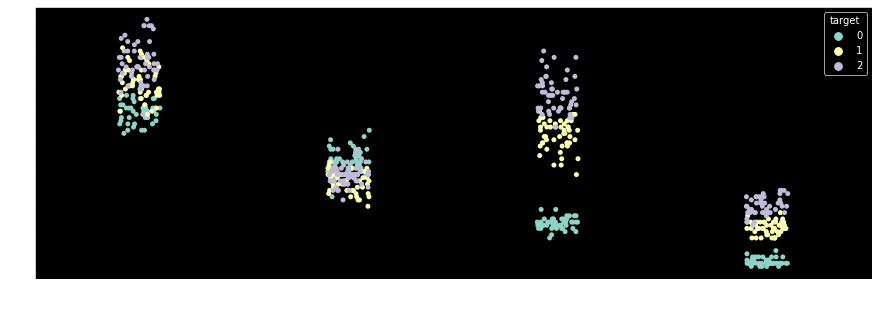

In [379]:
iris_modf_df = pd.melt(  irisX_df.merge( irisY_df, left_index= True, right_index= True ), id_vars= ['target'] )

fg,ax = plt.subplots( 1, figsize= (15,5) )
sns.stripplot(  x= 'variable', y= 'value', hue= 'target', data= iris_modf_df,
                jitter= True, edgecolor= 'white', ax= ax   );                        plt.show()

#### Apply `hyperopt` on `K-Nearest Neighbors` 

In [578]:
## hyper opt func

def hyperParamOptmz_Model_func( hparamSpace ):
    
    est_obj = sklearn.neighbors.KNeighborsClassifier( **hparamSpace )
    
    bestScore_model =  sklearn.model_selection.cross_val_score( estimator= est_obj, X= x, y= y, cv= 10, n_jobs= os.cpu_count()-1 ).mean()
    
    return(  { 'loss': -bestScore_model, 'status': hyperopt.STATUS_OK }  )

In [580]:
hyperParamSpace = {  'n_neighbors': hyperopt.hp.choice( 'n_neighbors', range(1,100) ),
                     'algorithm': hyperopt.hp.choice( 'algorithm', ['ball_tree','kd_tree'] ),
                     'leaf_size': hyperopt.hp.choice( 'leaf_size', range(10,50) )
                  }

x, y = irisX_df.to_numpy(), irisY_df.to_numpy()

trial_obj = hyperopt.Trials()

best_optmz_minModel = hyperopt.fmin( fn= hyperParamOptmz_Model_func, space= hyperParamSpace,
                                     algo= tpe.suggest, max_evals= 500, trials= trial_obj )

best_optmz_minModel

100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 35.95trial/s, best loss: -0.9800000000000001]


{'algorithm': 1, 'leaf_size': 26, 'n_neighbors': 12}

#### Accuracy vs hparams

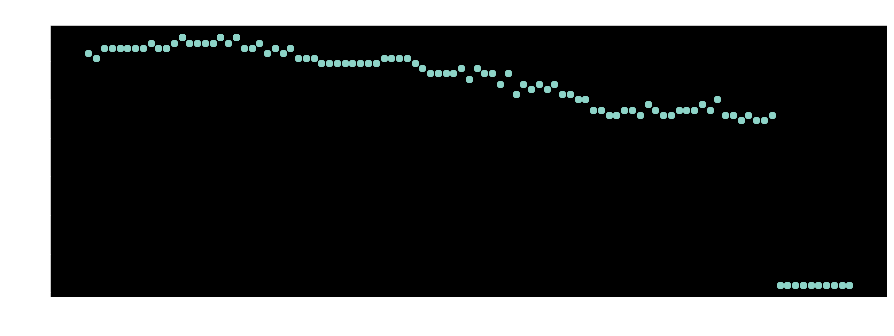

In [548]:
fg,ax = plt.subplots( 1, figsize= (15,5) )

x_nNeighbor = [  e_trial['misc']['vals']['n_neighbors'] for e_trial in trial_obj.trials  ]
y_accu = [  -e_trial['result']['loss'] for e_trial in trial_obj.trials  ]

ax.scatter( x_nNeighbor, y_accu )

ax.set_title( 'Iris Dataset - KNN hyperopt', fontsize= 15 ); ax.set( xlabel= 'n_neighbors', ylabel='cross validation accuracy' )
plt.show()

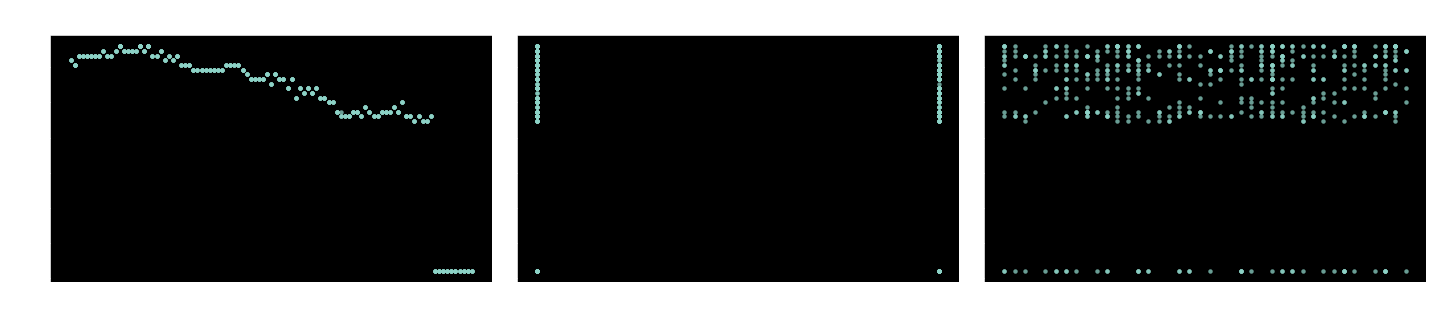

In [641]:
fg,ax = plt.subplots(  nrows= 1, ncols= len(hyperParamSpace), figsize= (20,4.5), sharey = True  )

for e_ax, e_hparam in zip( ax.flatten(),hyperParamSpace ):
    
    xx = np.array(   [ e_trial['misc']['vals'][e_hparam] for e_trial in trial_obj.trials  ]   ).ravel()
    yy = np.array(   [  -e_trial['result']['loss'] for e_trial in trial_obj.trials  ]   ).ravel()
    xx, yy = zip(  *sorted( zip(xx,yy) )  )                                                        # < -- optional step, can be safely/truly ignored 
    
    e_ax.scatter(  xx,yy, s= 20, linewidth= 0.01, alpha= 0.75  )
    
    e_ax.set( xlabel= e_hparam, ylabel= 'Accuracy' )  
    
fg.suptitle( 'Accuracy vs. hyper-params plot' ); 
plt.tight_layout(); plt.show()

<br>

### hyper param tuning multiple models

In [153]:
## data
iris_raw = sklearn.datasets.load_iris( as_frame= True )

# directly importing as dfs & series
irisX_df = iris_raw.data;                irisY_df = iris_raw.target

irisX_df = pd.DataFrame( sklearn.preprocessing.StandardScaler().fit_transform( irisX_df ), columns= irisX_df.columns )

X, y = irisX_df.to_numpy(), irisY_df.to_numpy()

X.shape

(150, 4)

In [159]:
## user input

digits_raw = datasets.load_digits()
X = digits_raw.data;    y = digits_raw.target
X, y = irisX_df.to_numpy(), irisY_df.to_numpy()

num_CV = 13 ; num_maxEval = 1000

trial_obj = hyperopt.Trials()
iterCount, currentBestModel, theBest = 0, 0, 0

def hyperParamOptmz_Model_func( hparamSpace ):
    
    global num_CV
    temp_hparamEst = hparamSpace['type'];    del hparamSpace['type']
    
    if temp_hparamEst == 'naive_bayes': est_obj = sklearn.naive_bayes.BernoulliNB(**hparamSpace)
    elif temp_hparamEst == 'svm': est_obj = sklearn.svm.SVC(**hparamSpace)
    elif temp_hparamEst == 'rForest': est_obj = sklearn.ensemble.RandomForestClassifier(**hparamSpace)
    elif temp_hparamEst == 'knn':  est_obj = sklearn.neighbors.KNeighborsClassifier(**hparamSpace)
    else: return(0)
    
    bestAccuracy_model =  sklearn.model_selection.cross_val_score( estimator= est_obj, X= X, y= y, n_jobs= os.cpu_count(), cv= num_CV ).mean()
    return( bestAccuracy_model )


def hyperParamOptmz_ModelLoss_wrapper( hparamSpace ):
    
    global iterCount, currentBestModel, theBest
    iterCount += 1
    
    bestOptAccuracy_model = hyperParamOptmz_Model_func( hparamSpace.copy() )
    
    # only output if there is overall increment
    if theBest < bestOptAccuracy_model:
        theBest = bestOptAccuracy_model
        print( '{:15}:   Accuracy --> {:1.2f} \t Hparam -->  {}'.format(hparamSpace['type'],bestOptAccuracy_model,hparamSpace ) )
    
    # Output notice @ every approx. 25% completion
    if iterCount/num_maxEval  in ( 0.25, 0.50, 0.75, 1.00 ):
        print(  '\n------------- \t {:3.0f}% complete \t # Iterations: {:6d}  ------------- \n'.format(iterCount/num_maxEval*100, iterCount)  ) 
    
    return { 'loss': -bestOptAccuracy_model,
             'status': hyperopt.STATUS_OK }


## hyper params space

hyperParamSpace_option_ls = [   {   'type': 'naive_bayes', 'alpha': hp.uniform('alpha', 0.0, 2.0)  },
                             
                                {   'type': 'svm', 'C': hp.uniform('C', 0, 10.0), 'gamma': hp.uniform('gamma', 0, 20.0),
                                                   'kernel': hp.choice('kernel', ['linear', 'rbf'])  },
                             
                                {   'type': 'rForest', 'max_depth': hp.choice('max_depth', range(1,20)), 'max_features': hp.choice('max_features', range(1,5)),
                                                   'n_estimators': hp.choice('n_estimators', range(1,20)), 'criterion': hp.choice('criterion', ['gini','entropy'])   },
                             
                                {   'type': 'knn', 'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))   } 
                            ]

hyperParamSpace = hyperopt.hp.choice(  label= 'classifier_type', options= hyperParamSpace_option_ls  )

currentBestModel = hyperopt.fmin( fn= hyperParamOptmz_ModelLoss_wrapper, space= hyperParamSpace, algo= tpe.suggest, max_evals= num_maxEval, trials= trial_obj )

print( f'\n\n--------------------------------------------------------------------------------------------------------------------------------------------------------------\
                        \t\t\tFinal best model -->  {currentBestModel}\n\
--------------------------------------------------------------------------------------------------------------------------------------------------------------' )

knn            :   Accuracy --> 0.87 	 Hparam -->  {'n_neighbors': 49, 'type': 'knn'}                                                                 
knn            :   Accuracy --> 0.96 	 Hparam -->  {'n_neighbors': 8, 'type': 'knn'}                                                                  
rForest        :   Accuracy --> 0.96 	 Hparam -->  {'criterion': 'gini', 'max_depth': 19, 'max_features': 3, 'n_estimators': 1, 'type': 'rForest'}    
svm            :   Accuracy --> 0.97 	 Hparam -->  {'C': 5.164306621113902, 'gamma': 10.48751147104706, 'kernel': 'linear', 'type': 'svm'}            
svm            :   Accuracy --> 0.97 	 Hparam -->  {'C': 5.923684712258808, 'gamma': 0.12310016678804558, 'kernel': 'rbf', 'type': 'svm'}             
                                                                                                                                                      
------------- 	  25% complete 	 # Iterations:    250  ------------- 

svm            :   Accur

<br>

### Genetic Algorithms


#### Library:`TPOT` is a Python Automated Machine Learning tool that optimizes ML pipelines using genetic programming. It returns the Python code of the pipeline.

Once `TPOT` is finished searching (or user stops it), it provides Python code for the best pipeline it found so user can tinker with the pipeline from there.

#### Genetics in Machine Learning:

>   
    - 1. Create multiple models (that have different sets of hyperparameters) ≡  [ample offsprings]
    - 2. We can pick the best model based on  our scoring func(s) ≡  [survival of the fittest
    - 3. Create new models that are similar to the best ones  ≡ [propagation of the fit to next generation]
    - 4. Add in some randomness so we don't reach a local optimum ≡ [  random mutations that sometime may give some offspring an advantage ]
    - 5. Repeat until the model improves or yield a desirable score
    
    


In [230]:
## data
iris_raw = sklearn.datasets.load_iris( as_frame= True )

# directly importing as dfs & series
irisX_df = iris_raw.data;                irisY_df = iris_raw.target

irisX_df = pd.DataFrame( sklearn.preprocessing.StandardScaler().fit_transform( irisX_df ), columns= irisX_df.columns )

# train test
X= irisX_df ;        irisY_df = irisY_df.to_numpy()

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split( irisX_df, irisY_df, stratify= irisY_df, test_size= 25./100, random_state= 10 )

# irisY_df.to_numpy()

In [247]:
# with high verbosity
tpot_obj = tpot.TPOTClassifier( generations= 120, population_size= 20, offspring_size= 15,
                                mutation_rate= 15/100, crossover_rate= 25/100,
                                scoring= 'accuracy', cv= 7,
                                n_jobs= -1, random_state= 10, verbosity= 3 )

tpot_obj.fit(  features= xtrn, target= ytrn )

tpot_obj.export( 'datasets/tpot_1_11142021.py' )

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/1820 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.9464285714285714	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.001, GradientBoostingClassifier__max_depth=7, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=4, GradientBoostingClassifier__min_samples_split=18, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.9464285714285714	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.001, GradientBoostingClassifier__max_depth=7, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=4, GradientBoostingClassifier__min_samples_split=18, GradientBoostingClassifier__n_estimators=100,

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 10 - Current Pareto front scores:

-1	0.9464285714285714	GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.001, GradientBoostingClassifier__max_depth=7, GradientBoostingClassifier__max_features=0.8500000000000001, GradientBoostingClassifier__min_samples_leaf=4, GradientBoostingClassifier__min_samples_split=18, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.6500000000000001)

-2	0.9732142857142857	GradientBoostingClassifier(FastICA(input_matrix, FastICA__tol=0.15000000000000002), GradientBoostingClassifier__learning_rate=0.1, GradientBoostingClassifier__max_depth=5, GradientBoostingClassifier__max_features=0.55, GradientBoostingClassifie

In [248]:
tpot_obj = tpot.TPOTClassifier( generations= 120, population_size= 20, offspring_size= 15,
                                mutation_rate= 15/100, crossover_rate= 25/100,
                                scoring= 'accuracy', cv= 7,
                                n_jobs= -1, random_state= 10, verbosity= 2 )

tpot_obj.fit(  features= xtrn, target= ytrn )

tpot_obj.export( 'datasets/tpot_1_11142021.py' )

Optimization Progress:   0%|          | 0/1820 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9464285714285714

Generation 2 - Current best internal CV score: 0.9464285714285714

Generation 3 - Current best internal CV score: 0.9553571428571429

Generation 4 - Current best internal CV score: 0.9732142857142857

Generation 5 - Current best internal CV score: 0.9732142857142857

Generation 6 - Current best internal CV score: 0.9732142857142857

Generation 7 - Current best internal CV score: 0.9732142857142857

Generation 8 - Current best internal CV score: 0.9732142857142857

Generation 9 - Current best internal CV score: 0.9732142857142857

Generation 10 - Current best internal CV score: 0.9732142857142857

Generation 11 - Current best internal CV score: 0.9732142857142857

Best pipeline: GradientBoostingClassifier(FastICA(input_matrix, tol=0.15000000000000002), learning_rate=0.1, max_depth=5, max_features=0.55, min_samples_leaf=11, min_samples_split=8, n_estimators=100, subsample=0.35000000000000003)


In [ ]:
import re

def clean_text(str_var):    
    '''
    clean the text, useful for column header
    Arguments:
    str_var -- a string variable of any size

    Return:
    str_modf -- a cleaned string variable
    '''
    # lower case and revome begin & end space
    str_modf = str_var.lower().strip()
    # replace all non word chars ( everything except letters and nos )
    str_modf = re.sub( pattern= r'[^\w\s]', repl= '_', string= str_modf )
    # replace all runs of whitespace with '_'
    str_modf = re.sub( pattern= r'\s+', repl= '_', string= str_modf )
    # repalce > 1 consecutive '_'
    str_modf = re.sub( pattern= r'[__]+', repl= '_', string= str_modf )
    # remove begining and trailing _ : '__any_word____' --> 'any_word'
    def _remove_begin_end_(str_var):
        while True:
            if str_var[-1] == '_':
                str_var = str_modf[:len(str_modf)-1]
            else:                
                break                
        while True:
            if str_var[0] == '_':                            
                str_var = str_modf[1:len(str_modf)]
            else:                
                break
        return(str_var)
    str_modf = _remove_begin_end_(str_modf)
    return(str_modf)    
clean_colm_name = lambda df: [ clean_text(e_cNm) for e_cNm in df.columns ]

from IPython.display import display_html

def display_side_by_side(*args):
    '''
    func to display pandas dfs side by side
    input: dfs
    '''
    html_str = ''
    for df in args:
        html_str += df.to_html( )
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )  
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )   
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )        
    display_html(  html_str.replace( "table", "table style= 'display:inline'" ),
                   raw=True  )
    
def display_side_by_side_head(*args):
    '''
    func to display pandas dfs side by side
    input: dfs
    '''
    html_str = ''
    for df in args:
        html_str += df.head(5).to_html( )
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False ) 
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False )    
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False )        
    display_html(  html_str.replace( "table", "table style= 'display:inline'" ),
                   raw=True  )
    
def print_tidy_JSON( json_data, indent_val = 6 ):
    print(  json.dumps( obj= json_data, indent= indent_val, sort_keys= True )  )
    
def get_numeric_colm( df, num= 26 ):
    '''
    returns the numeric column list (integer & float) from a dataframe
    Arguments:
        df is a dataframe
        num is the number of sampling to be considered for each column to check whether the column is numeric or not
    
    '''
    sample_num = min( len(df), num )
    numr_colm_ls = []
    for e_colm in df.columns:
        SerRndm1 = df[e_colm].dropna().sample( n= sample_num )
        if SerRndm1.str.isdecimal().sum() >= sample_num//2: 
            numr_colm_ls.append(e_colm)
        else:
            float_sum = 0
            for e_row in SerRndm1:
                try: float(e_row); float_sum += 1
                except: pass
            if float_sum >= sample_num: numr_colm_ls.append(e_colm)
    return(numr_colm_ls)